In [33]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START,END
from typing import TypedDict
from typing import Literal
import random  

In [36]:
from langchain_core.pydantic_v1 import BaseModel

class PydanticState(BaseModel):
    Key : int 

def node1(state: PydanticState):
    return {"Key": state.Key + 1}

def node2(state: PydanticState):
    return {"Key": state.Key + 1}

def node3(state: PydanticState):
    return {"Key": state.Key + 1}


In [38]:
builder = StateGraph(PydanticState)

builder.add_node("Node2", node2)

builder.add_edge(START, "Node2")
builder.add_edge("Node2", END)

simple_grap = builder.compile()

display(Image(simple_grap.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [18]:
result = simple_grap.invoke(PydanticState(Key=1))
print(result)

{'Key': 2}


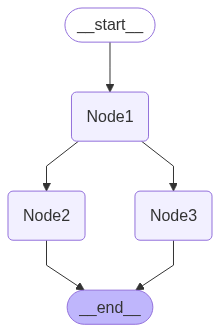

In [21]:
builder = StateGraph(PydanticState)

builder.add_node("Node1", node1)
builder.add_node("Node2", node2)
builder.add_node("Node3", node3)

builder.add_edge(START, "Node1")
builder.add_edge("Node1", "Node2")
builder.add_edge("Node1", "Node3")
builder.add_edge("Node2", END)

simple_grap = builder.compile()

display(Image(simple_grap.get_graph().draw_mermaid_png()))

In [23]:
from langgraph.errors import InvalidUpdateError
try:
    simple_grap.invoke(PydanticState(Key=1))
except InvalidUpdateError as e:
    print(f"Error occurred: {e}")

Error occurred: At key 'Key': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


In [48]:
from langchain_core.pydantic_v1 import BaseModel
from typing import Annotated
from operator import add
from pydantic import annotated_handlers
from typing import TypedDict

class TypedState(TypedDict):
    Key : Annotated[list[int],add] 

def node(state: TypedState):
    return {"Key": [state["Key"][0] + 1]}


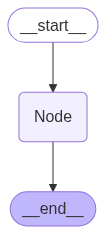

In [49]:
builder = StateGraph(TypedState)

builder.add_node("Node", node)

builder.add_edge(START, "Node")
builder.add_edge("Node", END)

simple_grap = builder.compile()

display(Image(simple_grap.get_graph().draw_mermaid_png()))

In [50]:
result = simple_grap.invoke({"Key": [1]})
print(result)

{'Key': [1, 2]}


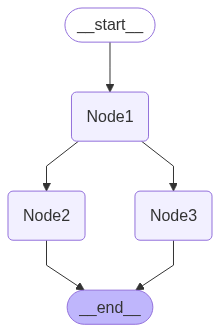

In [60]:
from typing import Annotated
from pydantic import BaseModel

int_list = Annotated[list[int], add]

class PydanticState(BaseModel):
    Key : int_list

def node1(state: PydanticState):
    return PydanticState(Key=[state.Key[0] + 1])

def node2(state: PydanticState):
    return PydanticState(Key=[state.Key[0] + 2])

def node3(state: PydanticState):
    return PydanticState(Key=[state.Key[0] + 3])

builder = StateGraph(PydanticState)

builder.add_node("Node1", node1)
builder.add_node("Node2", node2)
builder.add_node("Node3", node3)

builder.add_edge(START, "Node1")
builder.add_edge("Node1", "Node2")
builder.add_edge("Node1", "Node3")
builder.add_edge("Node3", END)

simple_grap = builder.compile()

display(Image(simple_grap.get_graph().draw_mermaid_png()))

In [61]:
result = simple_grap.invoke(PydanticState(Key=[0]))
print(result)

{'Key': [0, 1, 2, 3]}


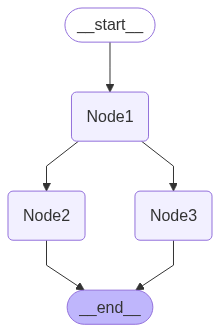

In [63]:
def custom_reducer(left : list | None , right : list | None) -> list:
    ''' custom reducer class '''
    if not left:
        left = []
    if not right:
        right = []
    return left + right

int_list = Annotated[list[int], custom_reducer]

class PydanticState(BaseModel):
    Key : int_list

def node1(state: PydanticState):
    return PydanticState(Key=[state.Key[0] + 1])

def node2(state: PydanticState):
    return PydanticState(Key=[state.Key[0] + 2])

def node3(state: PydanticState):
    return PydanticState(Key=[state.Key[0] + 3])

builder = StateGraph(PydanticState)

builder.add_node("Node1", node1)
builder.add_node("Node2", node2)
builder.add_node("Node3", node3)

builder.add_edge(START, "Node1")
builder.add_edge("Node1", "Node2")
builder.add_edge("Node1", "Node3")
builder.add_edge("Node3", END)

simple_grap = builder.compile()

display(Image(simple_grap.get_graph().draw_mermaid_png()))



In [ ]:
result = simple_grap.invoke(PydanticState(Key= []))
print(result)

ValidationError: 1 validation error for PydanticState
Key.0
  Input should be a valid integer [type=int_type, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/int_type

In [72]:
# messages 
# add_message custom reducer
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


message = Annotated[list[AnyMessage], add_messages]

class PydanticMessage(BaseModel):
    messages : message
    key_1 : str
    key_2 : str

class ExtendMessage(MessagesState):
    key_1 : str
    key_2 : str




In [77]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
initial_message = [HumanMessage(content="Hello, how are you?" , name="Akshay"),
                   AIMessage(content="I am fine, thank you!", name="system"),
                   ]

new_message = HumanMessage(content="i want some details about orcas?", name="Akshay")

final_message = add_messages(initial_message, new_message) 
for message in final_message:
    print(message.content)

Hello, how are you?
I am fine, thank you!
i want some details about orcas?


In [80]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
initial_message = [HumanMessage(content="Hello, how are you?" , name="Akshay" , id="1"),
                   AIMessage(content="I am fine, thank you!", name="system", id="2"),
                   HumanMessage(content="What can I do for you?", name="system", id="3"),
                   ]

new_message = HumanMessage(content="i want some details about orcas?", name="Akshay", id="3")

final_message = add_messages(initial_message, new_message) 
print(final_message)
for message in final_message:
    print(message.content)

[HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, name='Akshay', id='1'), AIMessage(content='I am fine, thank you!', additional_kwargs={}, response_metadata={}, name='system', id='2'), HumanMessage(content='i want some details about orcas?', additional_kwargs={}, response_metadata={}, name='Akshay', id='3')]
Hello, how are you?
I am fine, thank you!
i want some details about orcas?


In [90]:
# Remove message 

from langchain_core.messages import RemoveMessage

initial_message = [HumanMessage(content="Hello, how are you?" , name="Akshay" , id="1"),
                   AIMessage(content="I am fine, thank you!", name="system", id="2"),
                   HumanMessage(content="What can I do for you?", name="system", id="3"),
                   ]
initial_message.append(HumanMessage(content="i want some details about orcas?", name="Akshay", id="4"))
initial_message.append(HumanMessage(content="Tell me about orcas?", name="Akshay", id="5"))
deleted_message = [RemoveMessage(id=m.id) for m in initial_message[:-2]]
for i in deleted_message:
    print(i)

content='' additional_kwargs={} response_metadata={} id='1'
content='' additional_kwargs={} response_metadata={} id='2'
content='' additional_kwargs={} response_metadata={} id='3'


In [89]:
final_message = add_messages(initial_message, deleted_message)
for i in final_message:
    print(i.content)

i want some details about orcas?
Tell me about orcas?
